In [105]:
# import sklearn, just for fetching MNIST and for generating confusion matrices 
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# Dataset Setup

# Returns: 
# X_train, y_train, X_test, y_test
def get_data(dataset):
    np.random.seed(27)
    if dataset == 'iris':
        iris = datasets.load_iris()
        X = iris.data[:, :2]
        y = iris.target
    elif dataset == 'digits':
        digits = datasets.load_digits()
        X = digits.data[:]
        y = digits.target
    elif dataset == 'wine':
        wine = datasets.load_wine()
        X = wine.data[:]
        y = wine.target
    elif dataset == 'cancer':
        cancer = datasets.load_breast_cancer()
        X = cancer.data[:]
        y = cancer.target
    elif dataset == 'mnist':
        SUBSAMPLE_NUM = 500
        X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
        sub_indices = (y == '1') | (y == '3')
        X = X[sub_indices]
        y = y[sub_indices]
        X = X[:SUBSAMPLE_NUM, :]
        y = y[:SUBSAMPLE_NUM]
    elif dataset == 'nonlinear':
        X = np.random.randn(200, 2)
        y = np.logical_xor(X[:, 0] > 0,
                               X[:, 1] > 0)
        y = np.where(y, 1, -1)
    else:
        raise ValueError("Dataset string not recognized")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    return X_train, X_test, y_train, y_test

whole_X_train, X_test, whole_y_train, y_test = get_data(dataset='mnist')
# split further into train and val 
X_train, X_val, y_train, y_val = train_test_split(whole_X_train, whole_y_train, test_size=0.15, random_state=42)

In [56]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(382, 784)
(68, 784)
(50, 784)


### Label preprocessing

In [57]:
y_train_floats = [float(i) for i in y_train]
y_val_floats = [float(i) for i in y_val]
y_test_floats = [float(i) for i in y_test]
whole_y_train_floats = [float(i) for i in whole_y_train]

label_map = {}
unique_labels = set(y_train_floats)
assert(len(unique_labels) == 2)
flag = True       
for label in unique_labels:
    if flag:
        label_map[label] = 1
        flag = False
    else:
        label_map[label] = -1
print(label_map)

y_train_floats = np.array([label_map[label] for label in y_train_floats])
y_val_floats = np.array([label_map[label] for label in y_val_floats])
y_test_floats = np.array([label_map[label] for label in y_test_floats])
whole_y_train_floats = np.array([label_map[label] for label in whole_y_train_floats])

{1.0: 1, 3.0: -1}


#### Load kernels

In [58]:
%load_ext autoreload
%autoreload 2
from svm_from_scratch.kernels import kernel_rbf, kernel_poly, kernel_lin

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### SMO, Gaussian kernel

In [59]:
from svm_from_scratch.smo.smo import SMO

In [60]:
# Cross Validation
best_acc = float('-inf')
best_g = None
best_C = None 

best_accs = []
best_gs = []
best_Cs = []

for C in np.logspace(-1, 2, num=4):
    for g in np.logspace(-9, -5, num = 15):
        print("Testing for C = {}, g = {}".format(C, g))
        kernel = kernel_rbf(g)
        smo = SMO(X_train, y_train_floats, kernel, C)
        alphas, b = smo.run()        
        svm = SVMClassifier(alphas, X_train, y_train_floats, kernel)
        
        # test on acc 
        acc = svm.accuracy(X_val, y_val_floats, b)
        
        if acc > best_acc:
            best_acc = acc
            best_g = g
            best_C = C 
            
        if acc >= 0.9:
            best_accs.append(acc)
            best_gs.append(g)
            best_Cs.append(C)

Testing for C = 0.1, g = 1e-09


KeyboardInterrupt: 

In [63]:
print(best_C)
print(best_g)
print(best_acc)

10
1.389495494373136e-06
1.0


In [64]:
# Retrain on whole dataset with best g and best C, and test on test set

print("True labels: ", y_test_floats)
print("Using gamma = {} and C = {}".format(best_g, best_C))

kernel = kernel_rbf(best_g)
smo = SMO(whole_X_train, whole_y_train_floats, kernel, best_C)
alphas, b, smo_iterates, smo_outer_iterates= smo.run(store_iterates=True)   

svm = SVMClassifier(alphas, whole_X_train, whole_y_train_floats, kernel)

# Test set accuracy
acc = svm.accuracy(X_test, y_test_floats, b)
print("Test set acc: {}".format(acc))

True labels:  [ 1  1  1 -1  1  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1
 -1 -1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1  1 -1  1  1
 -1 -1]
Using gamma = 1.389495494373136e-06 and C = 10
predictions: [ 1.  1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1.
  1.  1.  1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1. -1.]
true labels: [ 1  1  1 -1  1  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1
 -1 -1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1  1 -1  1  1
 -1 -1]
num correct 49, accuracy 0.98
Test set acc: 0.98


In [101]:
smo_gauss_confusion_matrix = confusion_matrix(y_true=[1 , 1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1 , 1,  1, -1,  1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1, -1], y_pred = [ 1. , 1.,  1., -1. , 1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1., 1., -1.,  1. , 1.,  1., -1., -1., -1., -1., -1.,  1.,  1., -1.,  1., -1., -1., -1., -1., 1.,  1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.])
for i in range(smo_gauss_confusion_matrix.shape[0]): smo_gauss_confusion_matrix[i, i] = 0
smo_gauss_confusion_matrix

array([[0, 0],
       [1, 0]])

In [65]:
smo_norm_differences = []
alpha_star = smo_iterates[-1]
for iterate in smo_iterates:
    norm_diff = scipy.linalg.norm(iterate - alpha_star)
    smo_norm_differences.append(norm_diff)

smo_outer_norm_differences = []
alpha_star = smo_outer_iterates[-1]
for iterate in smo_outer_iterates:
    norm_diff = scipy.linalg.norm(iterate - alpha_star)
    smo_outer_norm_differences.append(norm_diff)

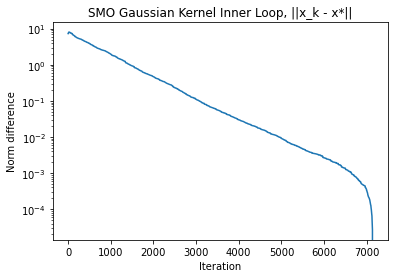

In [66]:
plt.semilogy(smo_norm_differences)
plt.xlabel('Iteration')
plt.ylabel('Norm difference')
plt.title('SMO Gaussian Kernel Inner Loop, ||x_k - x*||')
plt.savefig('SMO_gauss_inner.png')

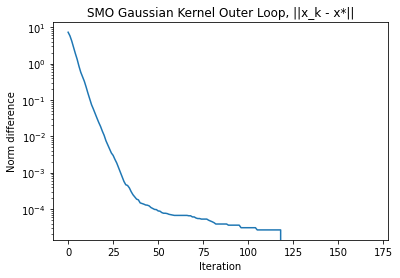

In [67]:
plt.semilogy(smo_outer_norm_differences)
plt.xlabel('Iteration')
plt.ylabel('Norm difference')
plt.title('SMO Gaussian Kernel Outer Loop, ||x_k - x*||')
plt.savefig('SMO_gauss_outer.png')

### SMO, Polynomial kernel

In [50]:
# Cross Validation
best_acc = float('-inf')
best_d = None
best_C = None 

best_accs = []
best_ds = []
best_Cs = []

for C in np.logspace(-1, 2, num=4):
    for d in np.arange(2, 8):
        print("Testing for C = {}, d = {}".format(C, d))
        kernel = kernel_poly(d=d)
        smo = SMO(X_train, y_train_floats, kernel, C)
        # alpha tol SUPER important for poly kernel
        if d < 3: alpha_tol = 1e-15
        elif d == 3: alpha_tol = 1e-20
        elif d == 4: alpha_tol = 1e-30
        elif d == 5: alpha_tol = 1e-35
        elif d == 6: alpha_tol = 1e-40
        elif d == 7: alpha_tol = 1e-47
        alphas, b = smo.run(max_passes=100, alpha_tol=alpha_tol)        
        svm = SVMClassifier(alphas, X_train, y_train_floats, kernel)

        # test on acc 
        acc = svm.accuracy(X_val, y_val_floats, b)

        if acc > best_acc:
            best_acc = acc
            best_d = d
            best_C = C 

        if acc >= 0.9:
            best_accs.append(acc)
            best_ds.append(d)
            best_Cs.append(C)

Testing for C = 0.1, d = 2
predictions: [-1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1.
 -1.  1. -1. -1. -1.  1.  1.  1. -1.]
true labels: [-1  1  1  1 -1  1  1  1  1  1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1
  1  1 -1]
num correct 27, accuracy 1.0
Testing for C = 0.1, d = 3
predictions: [-1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1.
 -1.  1. -1. -1. -1.  1.  1.  1. -1.]
true labels: [-1  1  1  1 -1  1  1  1  1  1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1
  1  1 -1]
num correct 26, accuracy 0.9629629629629629
Testing for C = 0.1, d = 4
predictions: [-1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1.
 -1.  1. -1. -1. -1.  1.  1.  1. -1.]
true labels: [-1  1  1  1 -1  1  1  1  1  1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1
  1  1 -1]
num correct 26, accuracy 0.9629629629629629
Testing for C = 0.1, d = 5
predictions: [-1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1.
 -1.  1. -1. -1. -1.  1.  

In [51]:
print(alphas)

[[ 4.24924019e-47]
 [ 7.84430116e-47]
 [ 2.53602714e-46]
 [ 0.00000000e+00]
 [ 5.89335966e-48]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.23513992e-46]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.12929561e-47]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.03884423e-47]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.51872669e-45]
 [ 0.00000000e+00]
 [ 1.22155160e-47]
 [ 0.00000000e+00]
 [ 1.48339105e-46]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.04686741e-47]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.51528190e-47]
 [ 1.66686182e-47]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.09080816e-47]
 [ 0.0000000

In [68]:
print(best_C)
print(best_d)
print(best_acc)

In [69]:
# Retrain on whole dataset with best d and best C, and test on test set

print("True labels: ", y_test_floats)
print("Using d = {} and C = {}".format(best_d, best_C))

kernel = kernel_poly(best_d)
smo = SMO(whole_X_train, whole_y_train_floats, kernel, best_C)
# remove this d later! 
if d < 3: alpha_tol = 1e-15
elif d == 3: alpha_tol = 1e-20
elif d == 4: alpha_tol = 1e-30
elif d == 5: alpha_tol = 1e-35
elif d == 6: alpha_tol = 1e-40
elif d == 7: alpha_tol = 1e-47

alphas, b, poly_smo_iterates, poly_smo_outer_iterates= smo.run(max_passes=100, alpha_tol=alpha_tol, store_iterates=True)   

svm = SVMClassifier(alphas, whole_X_train, whole_y_train_floats, kernel)

# Test set accuracy
acc = svm.accuracy(X_test, y_test_floats, b)
print("Test set acc: {}".format(acc))

True labels:  [ 1  1  1 -1  1  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1
 -1 -1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1  1 -1  1  1
 -1 -1]
Using d = 2 and C = 0.1
predictions: [ 1.  1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1.
  1.  1.  1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1. -1.]
true labels: [ 1  1  1 -1  1  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1
 -1 -1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1  1 -1  1  1
 -1 -1]
num correct 49, accuracy 0.98
Test set acc: 0.98


In [102]:
smo_poly_confusion_matrix = confusion_matrix(y_true=[ 1 , 1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1, -1], y_pred =[ 1. , 1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1., 1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1., -1.,  1., -1., -1., -1., -1., 1.,  1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.] )
for i in range(smo_poly_confusion_matrix.shape[0]): smo_poly_confusion_matrix[i, i] = 0
smo_poly_confusion_matrix

array([[0, 0],
       [1, 0]])

In [70]:
poly_smo_norm_differences = []
alpha_star = poly_smo_iterates[-1]
for iterate in poly_smo_iterates:
    norm_diff = scipy.linalg.norm(iterate - alpha_star)
    poly_smo_norm_differences.append(norm_diff)

poly_smo_outer_norm_differences = []
alpha_star = poly_smo_outer_iterates[-1]
for iterate in poly_smo_outer_iterates:
    norm_diff = scipy.linalg.norm(iterate - alpha_star)
    poly_smo_outer_norm_differences.append(norm_diff)

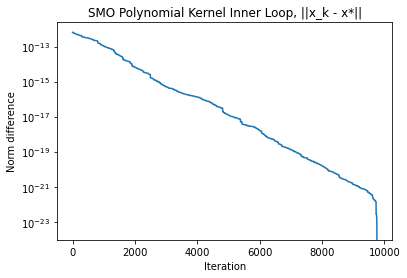

In [71]:
plt.semilogy(poly_smo_norm_differences)
plt.xlabel('Iteration')
plt.ylabel('Norm difference')
plt.title('SMO Polynomial Kernel Inner Loop, ||x_k - x*||')
plt.savefig('SMO_poly_inner.png')

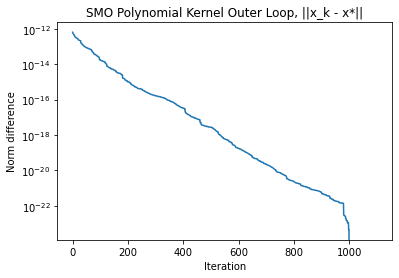

In [72]:
plt.semilogy(poly_smo_outer_norm_differences)
plt.xlabel('Iteration')
plt.ylabel('Norm difference')
plt.title('SMO Polynomial Kernel Outer Loop, ||x_k - x*||')
plt.savefig('SMO_poly_outer.png')

### Interior Point, Log Barrier, Gaussian Kernel 

In [83]:
from svm_from_scratch.log_barrier.svm import Barrier 
from svm_from_scratch.log_barrier.svm import SVMClassifier

In [84]:
barrier = Barrier()
# Cross Validation

best_acc = float('-inf')
best_g = None
best_C = None 

best_accs = []
best_gs = []
best_Cs = []

m = 2 * y_train_floats.shape[0] # number of constraints, two per Lagrange multiplier 
for C in np.logspace(-1, 3, num=5):
    for g in np.logspace(-10, -6, num = 15):
        kernel = kernel_rbf(g)
        lagrange_multipliers = barrier.run(X_train, y_train_floats, kernel, C, m)
        svm = SVMClassifier(lagrange_multipliers, X_train, y_train_floats, kernel)
        
        # test on acc 
        acc = svm.accuracy(X_val, y_val_floats)
        
        if acc > best_acc:
            best_acc = acc
            best_g = g
            best_C = C 
            
        if acc >= 0.9:
            best_accs.append(acc)
            best_gs.append(g)
            best_Cs.append(C)

Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.38877e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.17113e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.24693e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.75304e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.0482e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.78548e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.90608e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.33581e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.33304e-59): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.06092e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.10037e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.55644e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.65557e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.05443e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.03396e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.89199e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.44428e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.34909e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.43792e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.01478e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.37505e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.93673e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.76603e-32): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.87524e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.83172e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.4207e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.74845e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.27532e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.55273e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.85359e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.34814e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.39293e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.6059e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.01695e-32): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.48905e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.20429e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.0524e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.84816e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.40903e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.83578e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.87568e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 23
Finished iter: 24
Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.42658e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.34309e-31): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.05986e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.67408e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.56699e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.20518e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.98351e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.7301e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.60688e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.89432e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.8393e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.48025e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.59331e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.92594e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.41963e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.6957e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.26022e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.91533e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.82123e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.02011e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.4034e-51): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.13426e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.99983e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.16594e-59): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.10558e-31): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 8
Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.97716e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.68567e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.75775e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.69478e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.43097e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.90868e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.99169e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.1039e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.87006e-61): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.85987e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.50128e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.93832e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.55122e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.8432e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.50962e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.40534e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.94986e-51): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 65, accuracy 0.9558823529411765
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.92497e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 6
Finished iter: 7
Finished iter: 8


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.17969e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.1259e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 9
Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.18785e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.29559e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.81007e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.63092e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 65, accuracy 0.9558823529411765
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.87577e-32): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.68162e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.31014e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.02564e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.34015e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.75286e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.3757e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.84975e-51): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.53762e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.04777e-62): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.07048e-61): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.64479e-63): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.66669e-56): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.29772e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.01488e-57): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [ 1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 44, accuracy 0.6470588235294118


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.97949e-76): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.63644e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.32238e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.83175e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.64046e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.13844e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.47483e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.03236e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.74683e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20
Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.96435e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.33352e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.42855e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.47518e-55): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.19445e-59): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.65541e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.73889e-51): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.26316e-60): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.62199e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.74744e-51): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.70331e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.04384e-62): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.68721e-60): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.88642e-61): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.11296e-63): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24
Finished iter: 25
Finished iter: 26


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.02975e-63): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.1503e-71): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.91454e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.22749e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.09655e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.05281e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.16299e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.78556e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.35751e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.17699e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.90184e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.90847e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.24157e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.05154e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.42082e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.44444e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.5891e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.6276e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.42928e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.79665e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.62593e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.9355e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.74667e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.58703e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.37886e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.53655e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.14754e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.05994e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.08818e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.58641e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.13269e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.78409e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.75808e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.00782e-32): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.18545e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.04007e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.90644e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.11335e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.81977e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.24147e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.33571e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.21243e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 63, accuracy 0.9264705882352942
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.10565e-32): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.08811e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.11226e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.42541e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.25888e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.90146e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.33087e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.92722e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.78372e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.35337e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.49201e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.8261e-51): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.63692e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.87934e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.02936e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.74492e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20
Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.18168e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 65, accuracy 0.9558823529411765
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.00105e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.14146e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.09726e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.96064e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13
Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.37659e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.06621e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 63, accuracy 0.9264705882352942
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.03248e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 8
Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.32354e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.28128e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.60535e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.20907e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.73799e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.55778e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.45396e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.00028e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.69199e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 62, accuracy 0.9117647058823529
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.88104e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.87891e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.28723e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.89388e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.49575e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.5828e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.21245e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.00831e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.72038e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.41885e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.05571e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.71684e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.65919e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.39456e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.83362e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 63, accuracy 0.9264705882352942
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.93507e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.82834e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.0981e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.53994e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.34957e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.34207e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.13067e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.48567e-70): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.93052e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.22636e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.59597e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.27059e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.43413e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.03278e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.35442e-64): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.52998e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.21412e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.08448e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.19662e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.39538e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.88454e-55): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.23469e-56): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.55966e-55): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21
Finished iter: 22


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.99564e-73): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.75471e-61): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 23


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.91463e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.1849e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [ 1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 43, accuracy 0.6323529411764706
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.05854e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.68794e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.99699e-57): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.77735e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.15869e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.42435e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.37734e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.9483e-58): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.47043e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.52831e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.38806e-57): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.
 -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1. -1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 67, accuracy 0.9852941176470589
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.2652e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.13074e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.0228e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.61803e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.86702e-57): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.57749e-57): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.20354e-56): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.45804e-56): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.78777e-60): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.
  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 50, accuracy 0.7352941176470589
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.77716e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.15443e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.18213e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.0236e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.02757e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.24045e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.32491e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.20983e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.00272e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.29401e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.67685e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.59502e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.1149e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 52, accuracy 0.7647058823529411
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.32017e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.00206e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.33329e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.10719e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [ 1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 47, accuracy 0.6911764705882353
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.60713e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.9266e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.58496e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.35656e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.13897e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.01901e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.60577e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 65, accuracy 0.9558823529411765
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.32456e-32): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.89874e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.37414e-32): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.08331e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.95858e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.91614e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.18869e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.61063e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.89003e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.06949e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.45776e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.78206e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.64428e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.31741e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.90912e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.1173e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.19561e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 63, accuracy 0.9264705882352942
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.6059e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.99744e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.60499e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.87982e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.78692e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.74147e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.88124e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.19754e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.76679e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.72532e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.86095e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 61, accuracy 0.8970588235294118


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.93607e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.02368e-32): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.88223e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.5221e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.0383e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.11014e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.98599e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.69074e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.19674e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.28187e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.15035e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.49971e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.7689e-55): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 60, accuracy 0.8823529411764706
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.64896e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.83026e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.79517e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.49788e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.76273e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.03898e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 59, accuracy 0.8676470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.34538e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.23411e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.59724e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.3807e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.15889e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.18539e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.67503e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.05172e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.44029e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.60121e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.49988e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.5121e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.67511e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.04093e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.58953e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.6363e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.32446e-51): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 58, accuracy 0.8529411764705882


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.34836e-59): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.80402e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.95382e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.97816e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.55862e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.43333e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.57049e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.38037e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.91738e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.30452e-51): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.80799e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.26692e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.60832e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.68596e-55): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 55, accuracy 0.8088235294117647
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.23712e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.02083e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.06172e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.20638e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.05692e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.12842e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.24803e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.46921e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.09505e-61): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.92681e-60): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 62, accuracy 0.9117647058823529
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.34323e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.04674e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.38642e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.75498e-51): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.22736e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.13617e-68): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.32013e-62): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.18642e-56): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.6509e-65): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.70094e-68): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.13158e-57): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.73802e-72): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.78346e-73): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.79072e-71): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.87487e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.11884e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.94906e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.51144e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.79745e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.11842e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.85471e-56): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.70827e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.40758e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.4796e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.52986e-59): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.96558e-62): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.43193e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.19044e-58): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.98959e-58): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.95162e-66): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1. -1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 65, accuracy 0.9558823529411765
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.02443e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.17204e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.43196e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.66532e-59): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.16725e-56): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.67569e-57): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.17411e-62): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.9751e-55): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.17194e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.75246e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.24327e-56): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.81134e-58): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.21596e-63): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20
Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.76029e-66): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.52545e-70): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.13264e-64): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.80439e-66): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.67274e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.50722e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.99857e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.22322e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.38891e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 63, accuracy 0.9264705882352942
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.82616e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.21276e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.86599e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.64916e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.03113e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.08214e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.58833e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20
Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.2171e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.58961e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finis

/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.24213e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.09115e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.82317e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.72983e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 62, accuracy 0.9117647058823529
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.68514e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.08296e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.05903e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.3821e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.32808e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.00349e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19

/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.03241e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)



Finished iter: 20
Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.13413e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.10817e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 60, accuracy 0.8823529411764706
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.85527e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.30226e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.25765e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.36627e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.71537e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.95718e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.40895e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.92331e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24
Finished iter: 25
Finished iter: 26


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.07989e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.54629e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 58, accuracy 0.8529411764705882
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.78211e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.49549e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.00214e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.08601e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.39553e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.7202e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.54428e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.85886e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.50873e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.0937e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.99921e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.24959e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 58, accuracy 0.8529411764705882
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.49555e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.25025e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.51642e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.55655e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24
Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.55726e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 57, accuracy 0.8382352941176471
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.1212e-32): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 9
Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.32186e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.16572e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.10668e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.6879e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.84395e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.14329e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.84887e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.64651e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.95113e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.21397e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 56, accuracy 0.8235294117647058
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.72267e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.46642e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.66973e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.49077e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.43976e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.33055e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.81008e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.29238e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.22558e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.55231e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.75163e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 57, accuracy 0.8382352941176471
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.38365e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.08712e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.23648e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.41461e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.24521e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.48963e-51): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.97036e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21
Finished iter: 22


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.38413e-56): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 58, accuracy 0.8529411764705882
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.58373e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.45045e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.34629e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.26531e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.73226e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.67423e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.26339e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.03319e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.4973e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.16096e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.36124e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 60, accuracy 0.8823529411764706
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.84366e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 8
Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.75175e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10
Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.75431e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.58479e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.96625e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.66938e-51): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.24477e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.61641e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 62, accuracy 0.9117647058823529
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.97334e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.21198e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.83959e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.14237e-60): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.25855e-51): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.59989e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.21106e-51): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.18175e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.50189e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.73004e-66): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.11517e-67): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.31045e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.69375e-55): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.02605e-69): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.61253e-71): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24
Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.86761e-62): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.77566e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.60844e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.57175e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.91848e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.5559e-51): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.37305e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.53113e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.18397e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.35032e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.14856e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.6155e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.56705e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.24252e-60): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.42576e-57): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.02024e-64): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.48908e-67): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.47177e-62): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1. -1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 65, accuracy 0.9558823529411765
Finished iter: 0
Finished iter: 1


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.49782e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.94647e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.46673e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.90898e-61): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.31662e-56): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.77041e-55): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.20581e-61): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.29038e-63): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.34753e-59): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.63444e-57): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.53232e-66): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.06503e-69): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.8422e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.68696e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.82878e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.19912e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 60, accuracy 0.8823529411764706
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.83752e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 59, accuracy 0.8676470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finis

/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.92854e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.27366e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.77741e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.95105e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 58, accuracy 0.8529411764705882
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.95337e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.354e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.153e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.65491e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.198e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.57709e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 56, accuracy 0.8235294117647058
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.9118e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.30413e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.56503e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 57, accuracy 0.8382352941176471
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.49757e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.44552e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.94734e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.11905e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.60145e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.21996e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.00223e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.20117e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 56, accuracy 0.8235294117647058
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.17564e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.10764e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.63345e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.00773e-42): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.41832e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.57647e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 56, accuracy 0.8235294117647058
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.47942e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.9816e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.04402e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.19516e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.23119e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.17877e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.15154e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 56, accuracy 0.8235294117647058
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.79219e-33): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.32324e-43): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.86893e-37): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.13363e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.25007e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.8736e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.83906e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.1646e-58): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 55, accuracy 0.8088235294117647
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.47873e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.61443e-34): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.43384e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.63696e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.23736e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13
Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.46233e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.24997e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.36363e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 58, accuracy 0.8529411764705882
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.59149e-36): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.42448e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.06532e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.13194e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.99072e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.82778e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.39378e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.72982e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.33471e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.02248e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.94935e-60): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.44331e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.89504e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.21891e-35): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.78858e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.44643e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.33753e-38): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.09952e-40): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.45184e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.03938e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.47663e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.97325e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.04108e-44): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.843e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.26011e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.96571e-56): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.67777e-55): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.60316e-61): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 62, accuracy 0.9117647058823529
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.45835e-48): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.59083e-47): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.99128e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.08733e-60): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.50847e-39): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.45212e-55): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.93789e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.69343e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.233e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.29646e-58): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.22825e-56): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.81115e-56): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.58752e-45): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.68835e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.26592e-59): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.79845e-41): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.62883e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.6212e-60): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.52226e-55): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1. -1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 65, accuracy 0.9558823529411765


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.06727e-67): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1
Finished iter: 2


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.35515e-46): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 3


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.15966e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.80051e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.36978e-51): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.05736e-50): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.39857e-57): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.43279e-55): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.14195e-60): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.68242e-52): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.19837e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.1184e-59): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.65934e-64): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.19653e-58): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.33418e-61): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.43871e-65): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.26887e-60): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.81591e-64): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 42, accuracy 0.6176470588235294


In [85]:
print(best_C)
print(best_g)
print(best_acc)

1.0
5.179474679231202e-07
0.9852941176470589


In [86]:
# Retrain on whole dataset with best g and best C, and test on test set
barrier = Barrier()

m = 2 * y_train_floats.shape[0] # number of constraints, two per Lagrange multiplier 
print("True labels: ", y_test_floats)
print("Using gamma = {} and C = {}".format(best_g, best_C))

kernel = kernel_rbf(best_g)
lagrange_multipliers, barrier_iterates = barrier.run(whole_X_train, whole_y_train_floats, kernel, best_C, m, store_iterates = True)
svm = SVMClassifier(lagrange_multipliers, whole_X_train, whole_y_train_floats, kernel)

True labels:  [ 1  1  1 -1  1  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1
 -1 -1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1  1 -1  1  1
 -1 -1]
Using gamma = 5.179474679231202e-07 and C = 1.0
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.15023e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.87895e-49): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.68028e-53): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.10285e-68): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28


In [87]:
# test on acc 
acc = svm.accuracy(X_test, y_test_floats)
print("Test set acc: {}".format(acc))

predictions: [ 1.  1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1.
  1.  1.  1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1. -1.]
true labels: [ 1  1  1 -1  1  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1
 -1 -1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1  1 -1  1  1
 -1 -1]
num correct 49, accuracy 0.98
Test set acc: 0.98


In [103]:
ip_gauss_confusion_matrix = confusion_matrix(y_true=[ 1,  1,  1, -1,  1,  1,  1 ,-1, -1,  1, -1,  1, -1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1, -1], y_pred =[ 1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1., 1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1., -1.,  1., -1., -1., -1., -1. ,1.,  1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1. ,-1., -1.])
for i in range(ip_gauss_confusion_matrix.shape[0]): ip_gauss_confusion_matrix[i, i] = 0
ip_gauss_confusion_matrix

array([[0, 0],
       [1, 0]])

In [88]:
barrier_norm_differences = []
alpha_star = barrier_iterates[-1]
for iterate in barrier_iterates:
    norm_diff = scipy.linalg.norm(iterate - alpha_star)
    barrier_norm_differences.append(norm_diff)

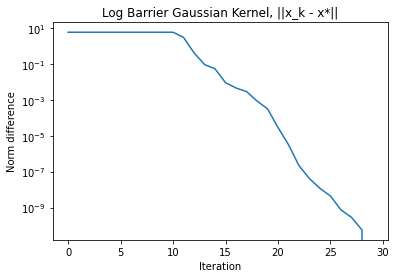

In [89]:
plt.semilogy(barrier_norm_differences)
plt.xlabel('Iteration')
plt.ylabel('Norm difference')
plt.title('Log Barrier Gaussian Kernel, ||x_k - x*||')
plt.savefig('IP_gauss.png')

### Interior Point, Log Barrier, Polynomial Kernel 

In [90]:
barrier = Barrier()
# Cross Validation

best_acc = float('-inf')
best_d = None
best_C = None 

best_accs = []
best_ds = []
best_Cs = []

m = 2 * y_train_floats.shape[0] # number of constraints, two per Lagrange multiplier 
for C in np.logspace(-2, 3, num=6):
    for d in np.arange(2, 8):
        kernel = kernel_poly(d)
        lagrange_multipliers = barrier.run(X_train, y_train_floats, kernel, C, m)
        svm = SVMClassifier(lagrange_multipliers, X_train, y_train_floats, kernel)
        
        # test on acc 
        acc = svm.accuracy(X_val, y_val_floats)
        
        if acc > best_acc:
            best_acc = acc
            best_d = d
            best_C = C 
            
        if acc >= 0.9:
            best_accs.append(acc)
            best_ds.append(d)
            best_Cs.append(C)

Finished iter: 0


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.91951e-66): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.2268e-63): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 6
Finished iter: 7
Finished iter: 8


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.68304e-65): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.06115e-75): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.4688e-84): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1. -1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 66, accuracy 0.9705882352941176


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.08151e-78): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.85675e-78): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.19624e-97): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.56903e-94): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.60779e-89): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.58022e-91): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.38913e-104): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.31721e-102): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.61786e-93): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.3812e-91): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.34474e-85): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.09943e-98): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 1
Finished iter: 2


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.61364e-104): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.06393e-114): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.07592e-107): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.7079e-115): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.12278e-121): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.42729e-125): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.61798e-128): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.80351e-130): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.00853e-121): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.02582e-123): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.46419e-125): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.04574e-133): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.17131e-135): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.62735e-135): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.17265e-147): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 63, accuracy 0.9264705882352942
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.43419e-139): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.65277e-141): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.17666e-150): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 62, accuracy 0.9117647058823529
Finished iter: 0


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.01888e-54): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 1


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.81001e-57): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 2
Finished iter: 3
Finished iter: 4


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.48311e-64): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.35621e-69): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.28058e-88): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.08516e-81): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.28561e-83): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.75826e-85): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.84179e-85): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.21923e-88): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1. -1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 66, accuracy 0.9705882352941176


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.26995e-91): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.5087e-68): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.07523e-80): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.71031e-81): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.5421e-79): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 2
Finished iter: 3


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.03284e-69): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 4
Finished iter: 5


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.64493e-84): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.4374e-104): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.89576e-84): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.22287e-98): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.94623e-126): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.09915e-126): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.24036e-105): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.97289e-136): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finis

/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.59151e-63): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.50758e-66): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 1


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.60739e-64): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.03491e-55): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.20502e-79): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.43297e-83): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 63, accuracy 0.9264705882352942


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.86417e-86): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.14746e-80): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 2
Finished iter: 3


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.12695e-70): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.33517e-111): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.45323e-95): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 1
Finished iter: 2


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.77818e-107): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.6833e-106): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1
Finished iter: 2


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.00154e-110): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.31088e-108): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.55923e-121): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finis

/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.38708e-79): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.29531e-80): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.94271e-66): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.01697e-82): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.25502e-76): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1. -1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 66, accuracy 0.9705882352941176


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.62353e-66): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.7366e-82): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.03994e-99): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.34844e-107): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20
Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.37198e-114): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.13599e-104): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.47121e-101): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.69246e-102): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 0


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.25018e-95): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 1


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.1071e-95): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 2


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.97936e-95): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 3


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.30977e-95): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 4


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.20497e-96): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.44775e-106): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.39212e-102): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.19254e-102): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.07338e-111): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1
Finished iter: 2


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.0209e-108): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 3
Finished iter: 4
Finished iter: 5


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.55794e-111): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.47356e-122): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.31186e-124): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.82761e-124): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finis

/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.18559e-73): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.8369e-67): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 1
Finished iter: 2


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.09668e-64): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 3


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.57953e-70): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 4


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.09721e-76): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 5


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.33142e-70): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.53836e-62): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.00002e-88): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.87153e-80): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.92059e-70): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.03874e-96): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.70075e-75): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.
 -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1. -1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 67, accuracy 0.9852941176470589
Finished iter: 0
Finished iter: 1


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.52679e-83): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.21506e-79): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.17628e-103): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.44577e-104): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.13594e-115): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.07405e-93): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.7601e-92): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 1


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.95626e-93): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.98181e-95): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.19979e-102): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.27042e-108): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.04801e-120): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.22129e-112): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1
F

/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.49719e-67): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.40248e-68): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=8.10063e-56): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.66536e-63): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 2
Finished iter: 3
Finished iter: 4


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.69725e-70): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=3.27019e-77): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.90611e-80): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 19
Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.27855e-85): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.49628e-74): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.42917e-91): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1. -1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 65, accuracy 0.9558823529411765
Finished iter: 0
Finished iter: 1


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.31562e-80): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=9.33304e-82): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 2


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=7.33561e-80): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.79676e-78): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.52341e-103): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.00916e-95): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=4.69839e-98): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.55434e-93): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.10855e-93): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.80304e-93): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=6.84032e-113): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.77703e-111): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.54135e-123): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.19756e-127): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)
/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=5.8345e-127): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28
predictions: [-1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]
true labels: [-1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1]
num correct 64, accuracy 0.9411764705882353
Finished iter: 0
Finished iter: 1
Finished iter: 2
Finished iter: 3
Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15
Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finis

In [91]:
print(best_C)
print(best_d)
print(best_acc)

100.0
2
0.9852941176470589


In [92]:
# Retrain on whole dataset with best d and best C, and test on test set
barrier = Barrier()

m = 2 * y_train_floats.shape[0] # number of constraints, two per Lagrange multiplier 
print("True labels: ", y_test_floats)
print("Using gamma = {} and C = {}".format(best_d, best_C))

kernel = kernel_poly(best_d)
lagrange_multipliers, poly_barrier_iterates = barrier.run(whole_X_train, whole_y_train_floats, kernel, best_C, m, store_iterates = True)
svm = SVMClassifier(lagrange_multipliers, whole_X_train, whole_y_train_floats, kernel)

True labels:  [ 1  1  1 -1  1  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1
 -1 -1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1  1 -1  1  1
 -1 -1]
Using gamma = 2 and C = 100.0
Finished iter: 0
Finished iter: 1
Finished iter: 2


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.5773e-66): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 3


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=1.93292e-76): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 4
Finished iter: 5
Finished iter: 6
Finished iter: 7
Finished iter: 8
Finished iter: 9
Finished iter: 10
Finished iter: 11
Finished iter: 12
Finished iter: 13
Finished iter: 14
Finished iter: 15


/Users/aneesh/Documents/Asp/Marshall/UCL/Numerical Optimisation/final/svm_from_scratch/log_barrier/svm.py:96: LinAlgWarning: Ill-conditioned matrix (rcond=2.41754e-79): result may not be accurate.
  solved = scipy.linalg.solve(KKT_mat, rhs)


Finished iter: 16
Finished iter: 17
Finished iter: 18
Finished iter: 19
Finished iter: 20
Finished iter: 21
Finished iter: 22
Finished iter: 23
Finished iter: 24
Finished iter: 25
Finished iter: 26
Finished iter: 27
Finished iter: 28


In [93]:
# test on acc 
acc = svm.accuracy(X_test, y_test_floats)
print("Test set acc: {}".format(acc))

predictions: [ 1.  1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1.
  1.  1.  1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1. -1.]
true labels: [ 1  1  1 -1  1  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1
 -1 -1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1  1 -1  1  1
 -1 -1]
num correct 48, accuracy 0.96
Test set acc: 0.96


In [104]:
ip_poly_confusion_matrix = confusion_matrix(y_true=[ 1,  1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1, -1], y_pred =[ 1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1., 1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., 1. , 1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1. ,-1., -1.])
for i in range(ip_poly_confusion_matrix.shape[0]): ip_poly_confusion_matrix[i, i] = 0
ip_poly_confusion_matrix

array([[0, 1],
       [1, 0]])

In [94]:
poly_barrier_norm_differences = []
alpha_star = poly_barrier_iterates[-1]
for iterate in poly_barrier_iterates:
    norm_diff = scipy.linalg.norm(iterate - alpha_star)
    poly_barrier_norm_differences.append(norm_diff)

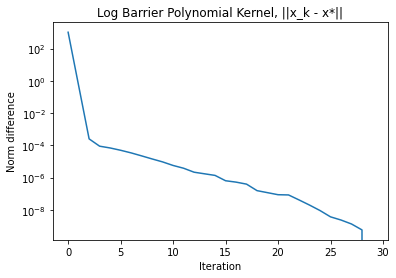

In [95]:
plt.semilogy(poly_barrier_norm_differences)
plt.xlabel('Iteration')
plt.ylabel('Norm difference')
plt.title('Log Barrier Polynomial Kernel, ||x_k - x*||')
plt.savefig('IP_poly.png')